# Import Package

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Global Parameters

In [2]:
OTR_Folder = 'Data/OTR/'
DAR_Folder = 'Data/Dart/'
OTR_path_dict = {}
DAR_path_dict = {}
for i in range(1,13):
    if i < 10:
        OTR_path_dict[i] = OTR_Folder + 'OTR_20190' + str(i) + '.csv'
        DAR_path_dict[i] = DAR_Folder + 'Dart_20190' + str(i) + '.csv'
    else:
        OTR_path_dict[i] = OTR_Folder + 'OTR_2019' + str(i) + '.csv'
        DAR_path_dict[i] = DAR_Folder + 'Dart_2019' + str(i) + '.csv'

# Loading Data

In [3]:
data_main_path = 'Data/Dart/'
data_trai_path_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
data_test_path_list = []

data_trai_list = []
data_test_list = []

print('Loading Train Data Sets')
for Mi in data_trai_path_list:
    trai_batch = pd.read_csv(DAR_path_dict[Mi])
    data_trai_list.append(trai_batch)
print('Loading Test Data Sets')
for Mi in data_test_path_list:
    test_batch = pd.read_csv(DAR_path_dict[Mi])
    data_test_list.append(test_batch)

Loading Train Data Sets
Loading Test Data Sets


# Preprocessing

## Utility Functions

In [4]:
key_cols = [
    'tps_planned_arrival_time', 'periods', 'station_name',
    'trip_orgin_station', 'trip_destination_station', 'trip_duration_sec',
    'segment_direction_name', 'tps_planned_departure_time',
    'planned_arrival_platform', 'car1_psngld_arrive', 'car1_psngld_depart',
    'car2_psngld_arrive', 'car2_psngld_depart', 'car3_psngld_arrive',
    'car3_psngld_depart', 'car4_psngld_arrive', 'car4_psngld_depart',
    'car5_psngld_arrive', 'car5_psngld_depart', 'car6_psngld_arrive',
    'car6_psngld_depart', 'car7_psngld_arrive', 'car7_psngld_depart',
    'car8_psngld_arrive', 'car8_psngld_depart', 'node_seq_order'
]

# Origin, Destination, Num of Stop

for i in range(len(key_cols)):
    key_cols[i] = key_cols[i].upper()


def get_station_name_labelEncoder(df):
    unique_station_np = df['station_name'.upper()].unique()
    unique_station_np = np.union1d(
        unique_station_np, df['trip_orgin_station'.upper()].unique())
    unique_station_np = np.union1d(
        unique_station_np, df['trip_destination_station'.upper()].unique())

    sn_le = LabelEncoder()
    sn_le.fit(unique_station_np)

    df.loc[:, 'station_name'.upper()] = sn_le.transform(
        df['station_name'.upper()])
    df.loc[:, 'trip_orgin_station'.upper()] = sn_le.transform(
        df['trip_orgin_station'.upper()])
    df.loc[:, 'trip_destination_station'.upper()] = sn_le.transform(
        df['trip_destination_station'.upper()])

    return df, sn_le


def get_platform_labelEncoder(df):
    unique_platform_np = df['planned_arrival_platform'.upper()].unique()

    p_le = LabelEncoder()
    p_le.fit(unique_platform_np)

    df.loc[:, 'planned_arrival_platform'.upper()] = p_le.transform(
        df['planned_arrival_platform'.upper()])

    return df, p_le

## Preprocessing Function

In [5]:
def preprocessing(df):

    # ===========================
    # filtering key columens
    # ===========================
    print('Filtering Key Columns')
    df = df[key_cols]

    # ===========================
    # convert datetime features
    # ===========================
    print('Converting Datetime Features')
    df.loc[:, 'tps_planned_arrival_time'.upper()] = pd.to_datetime(
        df['tps_planned_arrival_time'.upper()])
    df.loc[:, 'tps_planned_departure_time'.upper()] = pd.to_datetime(
        df['tps_planned_departure_time'.upper()])

    # ===========================
    # encoding categorical features
    # ===========================
    print('Encoding Categorical Features')
    df['PERIODS'].replace('Weekend', 0, inplace=True)
    df['PERIODS'].replace('Non-Peak', 1, inplace=True)
    df['PERIODS'].replace('PM Peak', 2, inplace=True)
    df['PERIODS'].replace('AM Peak', 3, inplace=True)
    df['SEGMENT_DIRECTION_NAME'].replace('Up', 0, inplace=True)
    df['SEGMENT_DIRECTION_NAME'].replace('Down', 1, inplace=True)

    # ===========================
    # creating dwell features
    # ===========================
    planned_dwell = (df['tps_planned_departure_time'.upper()] -
                     df['tps_planned_arrival_time'.upper()]
                     ).astype('timedelta64[s]')

    df['planned_dwell'.upper()] = planned_dwell

    # ===========================
    # creating time features
    # ===========================
    df['time_slot'.upper()] = 0
    time_slot_counter = 0
    for h in range(24):
        print('processing time slot on Hour:', h)
        for m in range(0, 60, 5):
            the_idx = (df['tps_planned_arrival_time'.upper()].dt.hour == h) & (
                (df['tps_planned_arrival_time'.upper()].dt.minute >= m) &
                (df['tps_planned_arrival_time'.upper()].dt.minute < m + 5))
            df.loc[the_idx, 'time_slot'.upper()] = time_slot_counter
            time_slot_counter += 1

    df['day_of_week'.upper()] = df['tps_planned_arrival_time'.upper()].dt.dayofweek
    
    df.drop([
        'tps_planned_arrival_time'.upper(),
        'tps_planned_departure_time'.upper()
    ],
            axis=1,
            inplace=True)

    return df

## Remove Null PSNGLD

In [6]:
WEIGHT_THRESHOLD = 30
print('Remove rows with all CARs\'s weights <', WEIGHT_THRESHOLD)
for i in range(len(data_trai_list)):
    print('Month', i + 1, 'before', data_trai_list[i].shape)
    PSNGLD_FEATURES = [
        'CAR1_PSNGLD_DEPART',
        'CAR2_PSNGLD_DEPART',
        'CAR3_PSNGLD_DEPART',
        'CAR4_PSNGLD_DEPART',
        'CAR5_PSNGLD_DEPART',
        'CAR6_PSNGLD_DEPART',
        'CAR7_PSNGLD_DEPART',
        'CAR8_PSNGLD_DEPART',
    ]
    #df[ ~ df['DEPARTUE_CARx'] == 0]
    left_idx = ~ (data_trai_list[i][PSNGLD_FEATURES] <= WEIGHT_THRESHOLD).all(axis=1)
    data_trai_list[i] = data_trai_list[i].loc[left_idx]
    
    print('Month', i + 1, 'after ', data_trai_list[i].shape)

Remove rows with all CARs's weights < 30
Month 1 before (573658, 28)
Month 1 after  (569969, 28)
Month 2 before (482976, 28)
Month 2 after  (478550, 28)
Month 3 before (555774, 28)
Month 3 after  (551860, 28)
Month 4 before (553348, 28)
Month 4 after  (548819, 28)
Month 5 before (550160, 28)
Month 5 after  (544998, 28)
Month 6 before (542683, 28)
Month 6 after  (539040, 28)
Month 7 before (554106, 28)
Month 7 after  (547889, 28)
Month 8 before (541757, 28)
Month 8 after  (536010, 28)
Month 9 before (556039, 28)
Month 9 after  (551327, 28)
Month 10 before (566089, 28)
Month 10 after  (561612, 28)
Month 11 before (519438, 28)
Month 11 after  (514257, 28)
Month 12 before (544240, 28)
Month 12 after  (538698, 28)


In [7]:
print('Remove Invaliad Data Instances')
for i in range(len(data_trai_list)):
    print('Month', i + 1, 'before', data_trai_list[i].shape)
    PSNGLD_FEATURES = [
        'CAR1_PSNGLD_DEPART',
        'CAR2_PSNGLD_DEPART',
        'CAR3_PSNGLD_DEPART',
        'CAR4_PSNGLD_DEPART',
        'CAR5_PSNGLD_DEPART',
        'CAR6_PSNGLD_DEPART',
        'CAR7_PSNGLD_DEPART',
        'CAR8_PSNGLD_DEPART',
        'CAR1_PSNGLD_ARRIVE',
        'CAR2_PSNGLD_ARRIVE',
        'CAR3_PSNGLD_ARRIVE',
        'CAR4_PSNGLD_ARRIVE',
        'CAR5_PSNGLD_ARRIVE',
        'CAR6_PSNGLD_ARRIVE',
        'CAR7_PSNGLD_ARRIVE',
        'CAR8_PSNGLD_ARRIVE',
    ]

    data_trai_list[i] = data_trai_list[i].dropna(how='any', subset=PSNGLD_FEATURES)
    print('Month', i + 1, 'after ', data_trai_list[i].shape)

Remove Invaliad Data Instances
Month 1 before (569969, 28)
Month 1 after  (555473, 28)
Month 2 before (478550, 28)
Month 2 after  (465365, 28)
Month 3 before (551860, 28)
Month 3 after  (537151, 28)
Month 4 before (548819, 28)
Month 4 after  (533492, 28)
Month 5 before (544998, 28)
Month 5 after  (531453, 28)
Month 6 before (539040, 28)
Month 6 after  (524819, 28)
Month 7 before (547889, 28)
Month 7 after  (533715, 28)
Month 8 before (536010, 28)
Month 8 after  (493747, 28)
Month 9 before (551327, 28)
Month 9 after  (533015, 28)
Month 10 before (561612, 28)
Month 10 after  (547762, 28)
Month 11 before (514257, 28)
Month 11 after  (498680, 28)
Month 12 before (538698, 28)
Month 12 after  (521302, 28)


## Sampling and Preprocessing

In [8]:
sample_size = 20000
r_seed = 1
print('Sampling', sample_size, 'data instances', 'from each Month with r_seed',
      r_seed)
data_trai_list_sampled = []
for df_m in data_trai_list:
    df_m_sample = df_m.sample(n=sample_size, random_state=r_seed)
    data_trai_list_sampled.append(df_m_sample)
   
print('Preprocessing sampled data')
data = pd.concat(data_trai_list_sampled, axis=0)
data = preprocessing(data)

temp_data = data.copy()
df_data, station_labelencoder = get_station_name_labelEncoder(temp_data)
df_data, platform_labelencoder = get_platform_labelEncoder(df_data)

Sampling 20000 data instances from each Month with r_seed 1
Preprocessing sampled data
Filtering Key Columns
Converting Datetime Features


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Encoding Categorical Features
processing time slot on Hour: 0


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


processing time slot on Hour: 1
processing time slot on Hour: 2
processing time slot on Hour: 3
processing time slot on Hour: 4
processing time slot on Hour: 5
processing time slot on Hour: 6
processing time slot on Hour: 7
processing time slot on Hour: 8
processing time slot on Hour: 9
processing time slot on Hour: 10
processing time slot on Hour: 11
processing time slot on Hour: 12
processing time slot on Hour: 13
processing time slot on Hour: 14
processing time slot on Hour: 15
processing time slot on Hour: 16
processing time slot on Hour: 17
processing time slot on Hour: 18
processing time slot on Hour: 19
processing time slot on Hour: 20
processing time slot on Hour: 21
processing time slot on Hour: 22
processing time slot on Hour: 23


## Spliting Features for Each Car

In [9]:
X_col = [
    'PERIODS', 'STATION_NAME', 'TRIP_ORGIN_STATION',
    'TRIP_DESTINATION_STATION', 'SEGMENT_DIRECTION_NAME',
    'PLANNED_ARRIVAL_PLATFORM', 'CAR1_PSNGLD_ARRIVE', 'CAR2_PSNGLD_ARRIVE',
    'CAR3_PSNGLD_ARRIVE', 'CAR4_PSNGLD_ARRIVE', 'CAR5_PSNGLD_ARRIVE',
    'CAR6_PSNGLD_ARRIVE', 'CAR7_PSNGLD_ARRIVE', 'CAR8_PSNGLD_ARRIVE',
    'NODE_SEQ_ORDER', 'PLANNED_DWELL', 'TIME_SLOT', 'DAY_OF_WEEK'
]

cat_features = [
    'periods',
    'station_name',
    'trip_orgin_station',
    'trip_destination_station',
    'planned_arrival_platform',
    'day_of_week',
    'time_slot'
]

for i in range(len(cat_features)):
    cat_features[i] = cat_features[i].upper()
    
for c in cat_features:
    df_data[c] = df_data[c].astype('category')
    
X = df_data[X_col]
Y_car_dict = {}

for car_id in range(1, 9):
    Y_car_dict[car_id] = df_data['CAR' + str(car_id) + '_PSNGLD_DEPART']

# Training Model

For each learning method

you will be given three fixed paramters
* x_train
* y_train
* car_id

and you need to return a model that has the function
* predict(x) -> y_hat

The parameters for your learning model can be passed through the
* **kwargs argument

## Build Model Main Function

In [10]:
def build_model(X, Y_car_dict, num_car, num_month, learning_method, **kwargs):
    car_Mi_dict = {}
    for car_id in range(1, num_car + 1):
        Mi_dict = {}
        Mi = 1
        # ===================================#
        # This kFold is to split data set as #
        # 11 Months Train and 1 Month Test   #
        # ===================================#
        kf = KFold(n_splits=num_month, shuffle=False)
        for train_index, test_index in kf.split(X):

            x_train = X.iloc[train_index]
            y_train = Y_car_dict[car_id].iloc[train_index]
            x_valid = X.iloc[test_index]
            y_valid = Y_car_dict[car_id].iloc[test_index]

            # *********************************** #
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
            # This is where your method is called #
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
            # *********************************** #
            model = learning_method(x_train, y_train, car_id, **kwargs)
            
            # ========== #
            # Prediction #
            # ========== #
            pred = model.predict(x_valid)
            
            # ============== #
            # Result Summary #
            # ============== #
            result = np.vstack([
                y_valid, pred, x_valid['PLANNED_ARRIVAL_PLATFORM'].values,
                x_valid['PERIODS'].values
            ])

            Mi_dict[Mi] = result
            Mi = Mi + 1

            mae = mean_absolute_error(y_valid, pred)
            print('Car', car_id, 'Month', Mi-1, 'MAE:', mae)
        car_Mi_dict[car_id] = Mi_dict
    return car_Mi_dict

# valid, pred, platform, periods, Month, car_id
# platform, month, periods, car1_residual, ...,
def process_result_to_dataframe(result_dict):
    result_pd_list = []
    for car_id in result_dict.keys():
        #print(lgb_result_pack_dict[car_id])
        car_id_np = None
        for Mi in result_dict[car_id].keys():
            result_size = result_dict[car_id][Mi].shape[1]
            if car_id_np is None:
                car_id_np = np.zeros(result_size)
                car_id_np = car_id_np + car_id
            month_np = np.zeros(result_size)
            month_np = month_np + Mi
            result_stack = np.vstack(
                [result_dict[car_id][Mi], month_np, car_id_np])
            result_df = pd.DataFrame(result_stack.T)
            result_df.columns = [
                'valid', 'pred', 'platform', 'periods', 'month', 'car_id'
            ]
            result_pd_list.append(result_df)
    result_pd = pd.concat(result_pd_list, axis=0)
    return result_pd



## Baseline Model

In [11]:
class baseline:
    def __init__(self, car_id):
        self.car_id = car_id
    def predict(self, X):
        if self.car_id not in [1, 2, 3, 4, 5, 6, 7, 8]:
            return 0
        result = X.copy()['CAR' + str(car_id) + '_PSNGLD_ARRIVE']
        result.replace(np.nan, 0, inplace=True)
        return result    
    
def baseline_model(x_train, y_train, car_id):
    model = baseline(car_id)
    return model

## Linear Regression Model

In [12]:
from sklearn.linear_model import LinearRegression

class myLR:
    def __init__(self):
        self.LR = LinearRegression()

    def fit(self, X, Y):
        self.LR.fit(X, Y)

    def predict(self, X):
        return self.LR.predict(X)
    
def build_LR(x_train, y_train, car_id):
    model = myLR()
    model.fit(x_train, y_train)
    return model

## LightGBM Model

In [13]:
import lightgbm as lgb
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,
    'num_leaves': 80,
    'learning_rate': 0.05
}

n_estimators = 1000

class LGB:
    def __init__(self, params, n_estimators, cat_features, X_valid, Y_valid):
        self.params = params
        self.n_estimators = n_estimators
        self.cat_features = cat_features
        data_valid = lgb.Dataset(X_valid,
                                 label=Y_valid,
                                 categorical_feature=cat_features)
        watchlist = [data_valid]
        self.watchlist = watchlist
        self.lgb = None

    def fit(self, X, Y):
        data_train = lgb.Dataset(X,
                                 label=Y,
                                 categorical_feature=self.cat_features)
        self.lgb = lgb.train(params,
                             data_train,
                             self.n_estimators,
                             self.watchlist,
                             verbose_eval=-1)

    def predict(self, X):
        return self.lgb.predict(X)


class Ensemble:
    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X):
        pred = None
        for e in self.estimators:
            if pred is None:
                pred = e.predict(X)
            else:
                pred = pred + e.predict(X)
        return pred / len(self.estimators)


def lgb_ensemble(x_train, y_train, car_id, num_ensemble, test_size, r_seed):
    ensemblers_car = []
    for i in range(num_ensemble):
        x_train_inFold, x_valid_inFold, y_train_inFold, y_valid_inFold = train_test_split(
            x_train, y_train, test_size=test_size, random_state=r_seed + i)

        ensembler = LGB(params, n_estimators, cat_features, x_valid_inFold, y_valid_inFold)
        ensembler.fit(x_train_inFold, y_train_inFold)
        ensemblers_car.append(ensembler)

    model = Ensemble(ensemblers_car)
    return model

## Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor

class myRFR:
    def __init__(self, n_estimator, max_depth, random_state):
        self.n_estimator = n_estimator
        self.max_depth = max_depth
        self.random_state = random_state
        self.RFR = RandomForestRegressor()

    def fit(self, X, Y):
        self.RFR.fit(X, Y)

    def predict(self, X):
        return self.RFR.predict(X)
    
def build_RFR(x_train, y_train, car_id, n_estimator, max_depth, random_state):
    model = myRFR(n_estimator, max_depth, random_state)
    model.fit(x_train, y_train)
    return model

## Deep Neural Network

In [63]:
from sklearn.neural_network import MLPRegressor

class myDNN:
    def __init__(self):
        self.DNN = MLPRegressor(hidden_layer_sizes = (20), 
                                activation = 'relu', 
                                solver = 'adam', 
                                learning_rate = 'adaptive', 
                                alpha = 0.0001, 
                                random_state = 123)

    def fit(self, X, Y):
        self.DNN.fit(X, Y)

    def predict(self, X):
        return self.DNN.predict(X)
    
def build_DNN(x_train, y_train, car_id):
    model = myDNN()
    model.fit(x_train, y_train)
    return model

## Add New Model  

  
  
  
  


<span style="font-size:3em;">This is just an template !</span>  





**Please DO NOT deletec this template**  
**Please DO NOT deletec this template**  
**Please DO NOT deletec this template**  

In [16]:
class new_model:
    def __init__(self):
        pass

    def fit(self, X, Y):
        pass

    def predict(self, X):
        return np.zeros(X.shape[0])


def build_new_model(x_train, y_train, car_id, **kwargs):
    model = new_model()
    model.fit(x_train, y_train)
    return model

In [17]:
# raw_result = build_model(X,
#                          Y_car_dict,
#                          num_car=1,
#                          num_month=12,
#                          learning_method=build_new_model)

# df_result = process_result_to_dataframe(raw_result)
# print('Total MAE', mean_absolute_error(df_result.valid, df_result.pred))

# Run Evaluation

## Evaluate Baseline Model

In [18]:
raw_result_baseline = build_model(X,
                         Y_car_dict,
                         num_car=8,
                         num_month=12,
                         learning_method=baseline_model)

df_result_baseline = process_result_to_dataframe(raw_result_baseline)
print('Total MAE', mean_absolute_error(df_result_baseline.valid, df_result_baseline.pred))

Car 1 Month 1 MAE: 827.5455
Car 1 Month 2 MAE: 824.268
Car 1 Month 3 MAE: 696.015
Car 1 Month 4 MAE: 674.113
Car 1 Month 5 MAE: 702.002
Car 1 Month 6 MAE: 655.532
Car 1 Month 7 MAE: 657.741
Car 1 Month 8 MAE: 692.0515
Car 1 Month 9 MAE: 649.046
Car 1 Month 10 MAE: 648.298
Car 1 Month 11 MAE: 667.7545
Car 1 Month 12 MAE: 585.767
Car 2 Month 1 MAE: 831.752
Car 2 Month 2 MAE: 941.5995
Car 2 Month 3 MAE: 961.7085
Car 2 Month 4 MAE: 907.6115
Car 2 Month 5 MAE: 981.1445
Car 2 Month 6 MAE: 929.948
Car 2 Month 7 MAE: 940.656
Car 2 Month 8 MAE: 983.6555
Car 2 Month 9 MAE: 935.908
Car 2 Month 10 MAE: 946.0335
Car 2 Month 11 MAE: 951.2905
Car 2 Month 12 MAE: 861.0215
Car 3 Month 1 MAE: 898.697
Car 3 Month 2 MAE: 1036.7015
Car 3 Month 3 MAE: 1030.9265
Car 3 Month 4 MAE: 996.466
Car 3 Month 5 MAE: 1067.456
Car 3 Month 6 MAE: 1030.3055
Car 3 Month 7 MAE: 1023.9235
Car 3 Month 8 MAE: 1055.8665
Car 3 Month 9 MAE: 1038.994
Car 3 Month 10 MAE: 1045.2785
Car 3 Month 11 MAE: 1069.8255
Car 3 Month 12 MAE: 

## Evaluate Linear Model

In [19]:
raw_result_LR = build_model(X,
                         Y_car_dict,
                         num_car=8,
                         num_month=12,
                         learning_method=build_LR)

df_result_LR = process_result_to_dataframe(raw_result_LR)
print('Total MAE', mean_absolute_error(df_result_LR.valid, df_result_LR.pred))

Car 1 Month 1 MAE: 281.4292873782204
Car 1 Month 2 MAE: 298.77541761138264
Car 1 Month 3 MAE: 304.3749188849479
Car 1 Month 4 MAE: 298.24098025812043
Car 1 Month 5 MAE: 306.5845876659854
Car 1 Month 6 MAE: 291.48603349472864
Car 1 Month 7 MAE: 298.13700809651624
Car 1 Month 8 MAE: 314.52835769308746
Car 1 Month 9 MAE: 297.202179918742
Car 1 Month 10 MAE: 299.2330489390673
Car 1 Month 11 MAE: 306.7256316516324
Car 1 Month 12 MAE: 264.5118404517792
Car 2 Month 1 MAE: 364.8454510391911
Car 2 Month 2 MAE: 401.50626430335285
Car 2 Month 3 MAE: 403.6333668328876
Car 2 Month 4 MAE: 395.6924092095
Car 2 Month 5 MAE: 410.4131511304199
Car 2 Month 6 MAE: 389.5727502269901
Car 2 Month 7 MAE: 397.21948321890903
Car 2 Month 8 MAE: 416.3730839524572
Car 2 Month 9 MAE: 400.15800089641505
Car 2 Month 10 MAE: 398.77262959270234
Car 2 Month 11 MAE: 405.6765171330157
Car 2 Month 12 MAE: 360.4170325255724
Car 3 Month 1 MAE: 379.247109405111
Car 3 Month 2 MAE: 420.6535994266838
Car 3 Month 3 MAE: 418.60710

## Evaluate LightGBM Model

In [22]:
learning_method_params = {'num_ensemble': 1, 'test_size': 0.2, 'r_seed': 1}
raw_result_lightGBM = build_model(X,
                         Y_car_dict,
                         num_car=8,
                         num_month=12,
                         learning_method=lgb_ensemble,
                         **learning_method_params)

df_result_lightGBM = process_result_to_dataframe(raw_result_lightGBM)
print('Total MAE', mean_absolute_error(df_result_lightGBM.valid, df_result_lightGBM.pred))

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 1 MAE: 189.05567949712943


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 2 MAE: 187.03038608917836


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 3 MAE: 190.63015048669808


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 4 MAE: 189.5397260545628


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 5 MAE: 184.19108141256496


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 6 MAE: 180.9161866655097


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 7 MAE: 178.18344521559123


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 8 MAE: 189.553094989816


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 9 MAE: 176.4997138135201


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 10 MAE: 182.38991191865372


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 11 MAE: 187.09404875151012


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 1 Month 12 MAE: 170.98993478087473


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 1 MAE: 239.22809826078145


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 2 MAE: 243.6726653775869


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 3 MAE: 243.44585951304092


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 4 MAE: 246.32812681475178


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 5 MAE: 242.46950116311038


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 6 MAE: 240.59810878862197


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 7 MAE: 233.55507465164865


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 8 MAE: 243.4449389274253


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 9 MAE: 235.6913718443521


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 10 MAE: 238.0156449838086


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 11 MAE: 243.47050459636222


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 2 Month 12 MAE: 233.90025102542614


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 1 MAE: 252.98064991798805


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 2 MAE: 255.86538337891716


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 3 MAE: 253.97275770879202


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 4 MAE: 264.6791926944717


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 5 MAE: 254.0835712894123


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 6 MAE: 253.63728106371673


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 7 MAE: 247.98861277473773


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 8 MAE: 256.7878093037885


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 9 MAE: 248.0376170888787


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 10 MAE: 255.44715275207622


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 11 MAE: 256.15480774158596


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 3 Month 12 MAE: 248.50266736394482


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 1 MAE: 248.01692165182163


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 2 MAE: 251.56613097496833


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 3 MAE: 252.50442482514694


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 4 MAE: 268.4506979391724


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 5 MAE: 251.57886922126366


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 6 MAE: 245.22570540210054


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 7 MAE: 244.64444132474307


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 8 MAE: 268.13006082916036


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 9 MAE: 237.42094251585564


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 10 MAE: 248.36958246943243


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 11 MAE: 253.12565052603506


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 4 Month 12 MAE: 241.7822978881954


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 1 MAE: 242.43672257852782


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 2 MAE: 251.3390514541124


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 3 MAE: 253.2525115310696


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 4 MAE: 594.1862374841742


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 5 MAE: 246.22639933824445


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 6 MAE: 249.0124196943848


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 7 MAE: 243.4340903522451


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 8 MAE: 244.8811351535792


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 9 MAE: 240.4406428823102


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 10 MAE: 248.0748508812421


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 11 MAE: 252.8847218935996


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 5 Month 12 MAE: 242.77107757340312


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 1 MAE: 248.36212449596013


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 2 MAE: 256.09863928913035


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 3 MAE: 255.71375517361312


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 4 MAE: 260.2949861435894


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 5 MAE: 254.5775177363553


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 6 MAE: 251.76114845558374


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 7 MAE: 246.5833697787378


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 8 MAE: 251.15925458850643


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 9 MAE: 245.4288214481963


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 10 MAE: 252.3955296439106


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 11 MAE: 254.42979428794928


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 6 Month 12 MAE: 245.7187621734092


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 1 MAE: 239.80431330847182


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 2 MAE: 257.662500868092


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 3 MAE: 252.806368693271


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 4 MAE: 255.83989838994066


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 5 MAE: 251.67965709971887


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 6 MAE: 239.4592206105465


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 7 MAE: 235.57605208974542


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 8 MAE: 242.54072470281412


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 9 MAE: 234.40322878294728


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 10 MAE: 242.11685568224695


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 11 MAE: 249.13599061844602


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 7 Month 12 MAE: 234.5626763016957


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 1 MAE: 176.21423308443048


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 2 MAE: 177.8718437088517


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 3 MAE: 183.2490584331161


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 4 MAE: 186.08026972646067


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 5 MAE: 183.38611939571052


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 6 MAE: 177.5389207511196


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 7 MAE: 177.45652361476067


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 8 MAE: 183.30139991055498


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 9 MAE: 176.4394509101293


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 10 MAE: 179.79406037847215


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 11 MAE: 180.73308861981909


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Car 8 Month 12 MAE: 166.86229003767926
Total MAE 235.05026087520432


## Evaluate Random Forest Regressor Model

In [23]:
learning_method_params = {'n_estimator': 50, 'max_depth': 10, 'random_state': 2}
raw_result_RF = build_model(X,
                         Y_car_dict,
                         num_car=8,
                         num_month=12,
                         learning_method=build_RFR,
                         **learning_method_params)

df_result_RF = process_result_to_dataframe(raw_result_RF)
print('Total MAE', mean_absolute_error(df_result_RF.valid, df_result_RF.pred))

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 1 MAE: 217.27253380050504


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 2 MAE: 224.67412076118327


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 3 MAE: 231.59302575396825


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 4 MAE: 235.09168181277056


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 5 MAE: 226.2029851190476


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 6 MAE: 222.40856836219336


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 7 MAE: 220.35846974275722


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 8 MAE: 236.17380709415585


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 9 MAE: 219.68753912698412


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 10 MAE: 223.83633305916305


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 11 MAE: 228.19830982683982


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 1 Month 12 MAE: 205.58682450091578


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 1 MAE: 283.2529353354978


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 2 MAE: 299.6271265873016


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 3 MAE: 302.69169868145747


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 4 MAE: 302.57686541514045


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 5 MAE: 298.2748112445887


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 6 MAE: 296.45383494047616


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 7 MAE: 287.66461277777773


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 8 MAE: 307.2076445328283


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 9 MAE: 293.5822963293651


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 10 MAE: 293.9569629671717


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 11 MAE: 300.500670197719


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 2 Month 12 MAE: 281.01760973124095


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 1 MAE: 297.39922481240984


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 2 MAE: 313.40498442279943


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 3 MAE: 312.43779704906206


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 4 MAE: 322.806013255772


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 5 MAE: 317.6819748214285


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 6 MAE: 310.0179795436508


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 7 MAE: 299.65315811507935


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 8 MAE: 319.9452524594156


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 9 MAE: 303.0709320833333


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 10 MAE: 313.182224004329


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 11 MAE: 316.32467337301586


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 3 Month 12 MAE: 295.19686771284273


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 1 MAE: 298.8589373069986


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 2 MAE: 313.7364258134921


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 3 MAE: 314.6449936706349


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 4 MAE: 317.5149970619658


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 5 MAE: 310.07982718253965


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 6 MAE: 309.2073041071428


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 7 MAE: 301.5919498679099


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 8 MAE: 319.8394951100288


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 9 MAE: 300.87926410173156


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 10 MAE: 309.00749811688314


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 11 MAE: 319.3646162680375


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 4 Month 12 MAE: 296.1205386273449


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 1 MAE: 294.8535547059884


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 2 MAE: 312.8987808712122


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 3 MAE: 313.81276398809524


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 4 MAE: 661.2577234343436


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 5 MAE: 312.029011933622


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 6 MAE: 308.3864183333334


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 7 MAE: 301.5901136904762


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 8 MAE: 312.7907160227273


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 9 MAE: 302.339484781746


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 10 MAE: 309.68217405483404


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 11 MAE: 318.92068890331893


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 5 Month 12 MAE: 297.5007514539627


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 1 MAE: 293.1121760551948


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 2 MAE: 313.014833495116


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 3 MAE: 315.3191939484127


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 4 MAE: 316.6126780645743


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 5 MAE: 313.9137539285714


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 6 MAE: 308.86303142857145


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 7 MAE: 304.7205455357143


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 8 MAE: 315.8966329743867


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 9 MAE: 305.7465026167582


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 10 MAE: 314.43328194083693


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 11 MAE: 317.75317129689756


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 6 Month 12 MAE: 297.3723585317461


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 1 MAE: 281.8302591432179


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 2 MAE: 304.7050661192974


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 3 MAE: 305.50559189393937


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 4 MAE: 304.46097145354645


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 5 MAE: 304.2770117612045


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 6 MAE: 291.600755813492


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 7 MAE: 290.5807141468254


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 8 MAE: 302.5022112087912


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 9 MAE: 289.14685470238095


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 10 MAE: 295.9191491702742


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 11 MAE: 301.8140381410256


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 7 Month 12 MAE: 277.4772202960928


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 1 MAE: 212.43629093253966


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 2 MAE: 220.6149608531746


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 3 MAE: 225.2486495328283


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 4 MAE: 226.00539869047617


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 5 MAE: 227.46333473845598


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 6 MAE: 217.55429067460318


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 7 MAE: 219.3181153571429


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 8 MAE: 228.6992392063492


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 9 MAE: 219.30530504884004


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 10 MAE: 224.79614710678212


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 11 MAE: 225.50387210678213


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Car 8 Month 12 MAE: 203.7304720238095
Total MAE 287.8455672781376


## Evaluate Deep Neural Network

In [66]:
raw_result_DNN = build_model(X,
                             Y_car_dict,
                             num_car=8,
                             num_month=12,
                             learning_method=build_DNN)

df_result_DNN = process_result_to_dataframe(raw_result_DNN)
print('Total MAE', mean_absolute_error(df_result_DNN.valid,
                                       df_result_DNN.pred))

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 1 MAE: 264.45819717359916


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 2 MAE: 286.3234471106813
Car 1 Month 3 MAE: 293.69649609615107


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 4 MAE: 292.65155267373535


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 5 MAE: 296.54182392863316


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 6 MAE: 280.809543794745
Car 1 Month 7 MAE: 282.7157073682343


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 8 MAE: 299.40241230712195


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 9 MAE: 284.09834490210574


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 10 MAE: 283.0591872662452


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 11 MAE: 293.72690584389477


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 1 Month 12 MAE: 257.6540760906951


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 1 MAE: 345.43406542118976


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 2 MAE: 371.6749689566779


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 3 MAE: 373.86707850822546


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 4 MAE: 377.70957085911834


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 5 MAE: 385.21538170481546


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 6 MAE: 364.3900288537039


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 7 MAE: 368.47751481368084


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 8 MAE: 392.2557637831751


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 9 MAE: 375.7878418389803


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 10 MAE: 369.461371692233
Car 2 Month 11 MAE: 392.1992054737285


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 2 Month 12 MAE: 338.6637888641383


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 1 MAE: 361.18801180106203


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 2 MAE: 389.25540121099294


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 3 MAE: 385.9718181950078


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 4 MAE: 411.8695891335491


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 5 MAE: 397.46734008287325
Car 3 Month 6 MAE: 377.73702355498074


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 7 MAE: 387.2698211448528


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 8 MAE: 411.46343132270886


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 9 MAE: 391.7112263903978


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 10 MAE: 390.9182984206548


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 3 Month 11 MAE: 400.6908757014662
Car 3 Month 12 MAE: 360.91677466032655


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 1 MAE: 379.91438159415674
Car 4 Month 2 MAE: 398.26354473288205


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 3 MAE: 394.79479833858807


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 4 MAE: 526.9483587018528


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 5 MAE: 396.4707210106435


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 6 MAE: 383.9986123658929


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 7 MAE: 390.43763908812605


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 8 MAE: 419.1614220890853


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 9 MAE: 390.96397451506357


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 10 MAE: 392.06522880141506


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 11 MAE: 407.8901863569475


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 4 Month 12 MAE: 367.03253121607906


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 1 MAE: 372.8841200574697


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 2 MAE: 396.65031183220367


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 3 MAE: 393.79861528741884


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 4 MAE: 590.9905845198718


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 5 MAE: 399.06521654775383


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 6 MAE: 389.7765889745717


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 7 MAE: 395.08117477818325


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 8 MAE: 406.3938345124227


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 9 MAE: 389.02309525040005


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 10 MAE: 392.9338108893832


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 11 MAE: 406.41553537247216


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 5 Month 12 MAE: 374.8191293866342


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 1 MAE: 361.03925001170916


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 2 MAE: 397.6693995785766
Car 6 Month 3 MAE: 399.88850699811906
Car 6 Month 4 MAE: 419.8167669907055


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 5 MAE: 398.46690434173667


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 6 MAE: 378.39563876947386


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 7 MAE: 393.39756938613687


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 8 MAE: 407.4152833367735


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 9 MAE: 388.1710430642321


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 10 MAE: 388.9044276403869


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 11 MAE: 396.6480659152235


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 6 Month 12 MAE: 363.5559307423693


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 7 Month 1 MAE: 334.99782197228006
Car 7 Month 2 MAE: 372.9588413914902


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 7 Month 3 MAE: 381.95091005794774


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 7 Month 4 MAE: 402.9639104872418
Car 7 Month 5 MAE: 383.28489816007846


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 7 Month 6 MAE: 364.4334479245297


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 7 Month 7 MAE: 372.0399071643637


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 7 Month 8 MAE: 385.0649365006405
Car 7 Month 9 MAE: 377.27826470610074
Car 7 Month 10 MAE: 374.79684622083124
Car 7 Month 11 MAE: 381.8343115019225


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 7 Month 12 MAE: 341.8160797714022


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 1 MAE: 256.0456692684831


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 2 MAE: 276.36726582961063


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 3 MAE: 278.8855924227831


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 4 MAE: 294.2217599126948


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 5 MAE: 291.9735776788573


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 6 MAE: 275.08583088899076


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 7 MAE: 284.3520718395018


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 8 MAE: 292.9390180222293


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 9 MAE: 283.9364195368907
Car 8 Month 10 MAE: 287.11891982322055
Car 8 Month 11 MAE: 289.78809310647136


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Car 8 Month 12 MAE: 249.8102312337493
Total MAE 362.7064657850174


# Results Anaylsis

In [53]:
def plot_residual_by_platform(df,
                              top_k,
                              p_le,
                              extra_title_info="",
                              show_plot=False):
    unique_platform_list = df['platform'].unique()
    residual_list = []
    for p_id in unique_platform_list:
        df_platform = df.loc[df['platform'] == p_id]
        platform_mae = mean_absolute_error(df_platform['valid'].values,
                                           df_platform['pred'].values)
        residual_list.append(platform_mae)
    residual_list = np.array(residual_list)
    if top_k == -1:
        top_idx = residual_list.argsort()[::-1]
    else:
        top_idx = residual_list.argsort()[-top_k:][::-1]
    p_code = p_le.inverse_transform(unique_platform_list[top_idx].astype(int))
    if show_plot:
        x = np.arange(top_k)
        plt.bar(x, residual_list[top_idx], tick_label=p_code)
        plt.xticks(rotation=45)
        plt.title('Residual by Platform with Top ' + str(top_k) + ', ' +
                  extra_title_info)
        plt.xlabel('platform')
        plt.ylabel('MAE')
        plt.show()
    return unique_platform_list[top_idx], residual_list[top_idx]


def plot_residual_by_car(df, extra_title_info="", show_plot=False):
    unique_list = df['car_id'].unique()
    residual_list = []
    for u_id in unique_list:
        df_selected = df.loc[df['car_id'] == u_id]
        the_mae = mean_absolute_error(df_selected['valid'].values,
                                      df_selected['pred'].values)
        residual_list.append(the_mae)
    residual_list = np.array(residual_list)

    if show_plot:
        plt.bar(unique_list, residual_list)
        plt.title('Residual by CarID, ' + extra_title_info)
        plt.xlabel('CarID')
        plt.ylabel('MAE')
        plt.show()
    return residual_list


def plot_residual_by_month(df, extra_title_info="", show_plot=False):
    month_list = np.arange(1, 13)
    residual_list = []
    for Mi in month_list:
        df_selected = df.loc[df['month'] == Mi]
        the_mae = mean_absolute_error(df_selected['valid'].values,
                                      df_selected['pred'].values)
        residual_list.append(the_mae)
    residual_list = np.array(residual_list)

    if show_plot:
        plt.bar(month_list, residual_list)
        plt.title('Residual by Month, ' + extra_title_info)
        plt.xlabel('Month')
        plt.ylabel('MAE')
        plt.show()
    return residual_list


def plot_group_bar_result(residual_list, residual_label, xticks_list,
                          title_info, x_label, y_label):
    barWidth = 1 / (len(residual_list) + 1)
    bar_x = np.arange(len(residual_list[0]))
    for residual_id, residual in enumerate(residual_list):
        plt.bar(bar_x,
                residual,
                width=barWidth,
                edgecolor='white',
                label=residual_label[residual_id])
        bar_x = [x + barWidth for x in bar_x]

    # Add xticks on the middle of the group bars
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks([r + barWidth for r in range(len(residual_list[0]))],
               xticks_list)
    plt.title(title_info)
    # Create legend & Show graphic
    plt.legend()
    plt.show()


def plot_best_worst_platform(plt_order1, plt_order2, top_k, residual_label):
    plt_order_improve = plt_order1 - plt_order2
    r_improve_hig_idx = np.argsort(plt_order_improve)
    r_improve_low_idx = np.argsort(plt_order_improve)[::-1]
    hig = r_improve_hig_idx[:top_k]
    low = r_improve_low_idx[:top_k]

    residual_list = [plt_order1[hig], plt_order2[hig]]
    xticks_list = platform_labelencoder.inverse_transform(hig)
    title_info = 'The Top ' + str(top_k) + ' Improvement, ' + residual_label[
        0] + ' vs. ' + residual_label[1]
    x_label = 'Platform'
    y_label = 'MAE'
    plot_group_bar_result(residual_list, residual_label, xticks_list,
                          title_info, x_label, y_label)

    residual_list = [plt_order1[low], plt_order2[low]]
    xticks_list = platform_labelencoder.inverse_transform(low)
    title_info = 'The Last ' + str(top_k) + ' Improvement, ' + residual_label[
        0] + ' vs. ' + residual_label[1]
    x_label = 'Platform'
    y_label = 'MAE'
    plot_group_bar_result(residual_list, residual_label, xticks_list,
                          title_info, x_label, y_label)

## Plot Residual by Platform

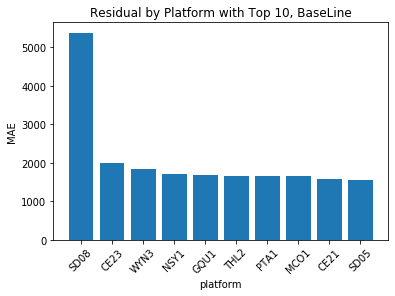

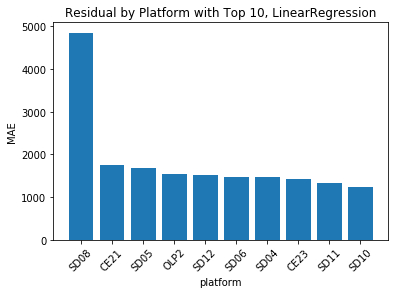

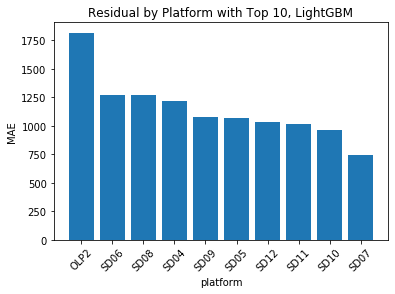

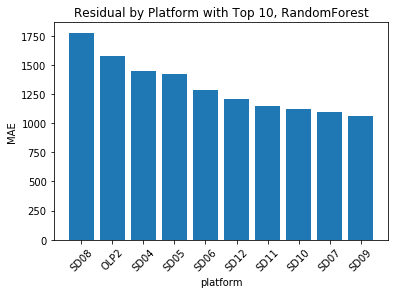

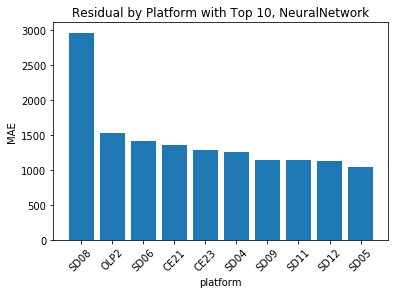

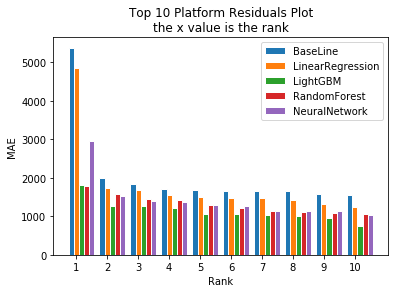

In [67]:
top_k = 10
show_plot = True

p_id_bl, r_platform_BL = plot_residual_by_platform(df_result_baseline, top_k,
                                                   platform_labelencoder,
                                                   'BaseLine', show_plot)

p_id_lr, r_platform_LR = plot_residual_by_platform(df_result_LR, top_k,
                                                   platform_labelencoder,
                                                   'LinearRegression',
                                                   show_plot)

p_id_lg, r_platform_LG = plot_residual_by_platform(df_result_lightGBM, top_k,
                                                   platform_labelencoder,
                                                   'LightGBM',
                                                   show_plot)

p_id_rf, r_platform_RF = plot_residual_by_platform(df_result_RF, top_k,
                                                   platform_labelencoder,
                                                   'RandomForest',
                                                   show_plot)

p_id_NN, r_platform_NN = plot_residual_by_platform(df_result_DNN, top_k,
                                                   platform_labelencoder,
                                                   'NeuralNetwork',
                                                   show_plot)


residual_list = [r_platform_BL, r_platform_LR, r_platform_LG, r_platform_RF,r_platform_NN]
residual_label = ['BaseLine', 'LinearRegression', 'LightGBM', 'RandomForest','NeuralNetwork']
xticks_list = np.arange(1, top_k + 1)
title_info = 'Top ' + str(
    top_k) + ' Platform Residuals Plot\n' + 'the x value is the rank'
x_label = 'Rank'
y_label = 'MAE'

plot_group_bar_result(residual_list, residual_label, xticks_list, title_info,
                      x_label, y_label)

## Plot Residual by Car

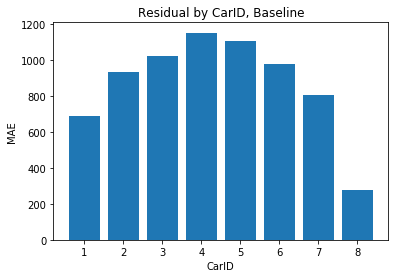

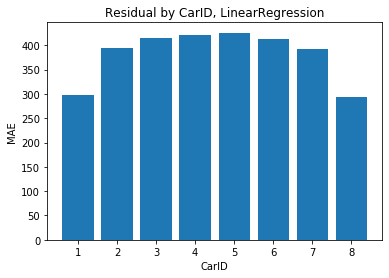

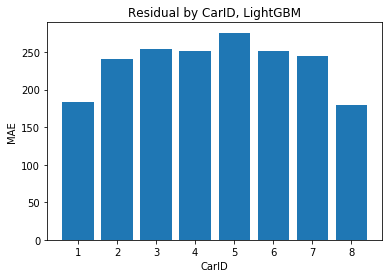

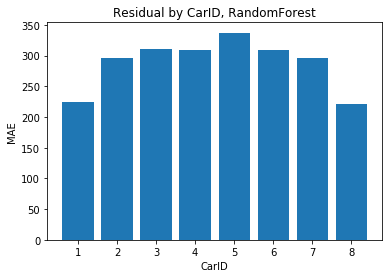

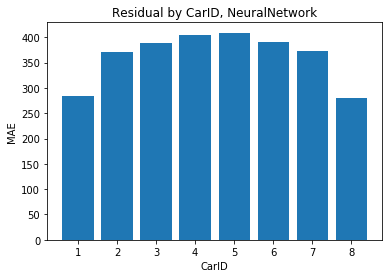

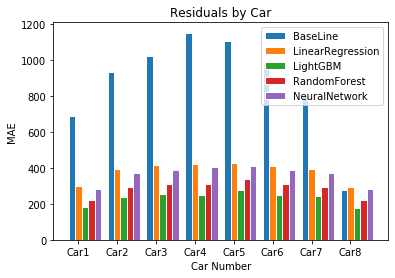

In [68]:
show_plot = True
r_car_BL = plot_residual_by_car(df_result_baseline, 'Baseline', show_plot)
r_car_LR = plot_residual_by_car(df_result_LR, 'LinearRegression', show_plot)
r_car_LG = plot_residual_by_car(df_result_lightGBM, 'LightGBM', show_plot)
r_car_RF = plot_residual_by_car(df_result_RF, 'RandomForest', show_plot)
r_car_NN = plot_residual_by_car(df_result_DNN, 'NeuralNetwork', show_plot)

residual_list = [r_car_BL, r_car_LR, r_car_LG, r_car_RF,r_car_NN]
residual_label = ['BaseLine', 'LinearRegression', 'LightGBM', 'RandomForest', 'NeuralNetwork']
xticks_list = ['Car1', 'Car2', 'Car3', 'Car4', 'Car5', 'Car6', 'Car7', 'Car8']
title_info = 'Residuals by Car'
x_label = 'Car Number'
y_label = 'MAE'

plot_group_bar_result(residual_list, residual_label, xticks_list, title_info,
                      x_label, y_label)

## Plot Residual by Month

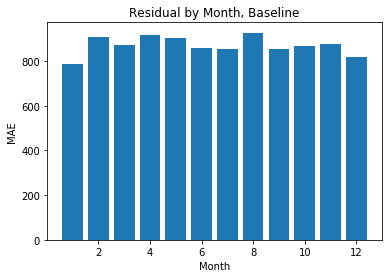

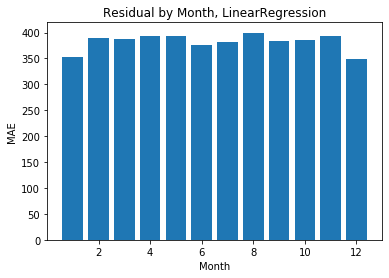

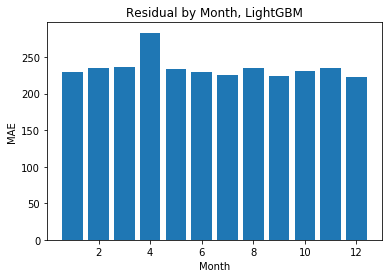

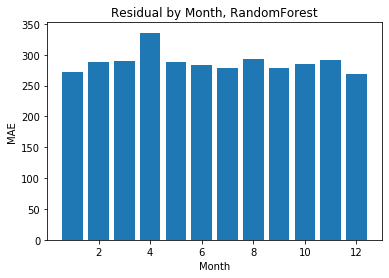

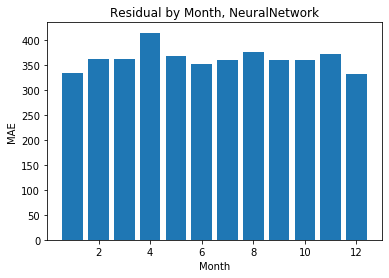

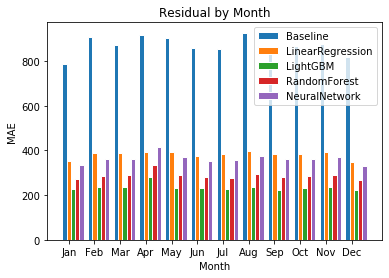

In [70]:
show_plot = True
r_month_BL = plot_residual_by_month(df_result_baseline, 'Baseline', show_plot)
r_month_LR = plot_residual_by_month(df_result_LR, 'LinearRegression',
                                    show_plot)
r_month_LG = plot_residual_by_month(df_result_lightGBM, 'LightGBM', show_plot)
r_month_RF = plot_residual_by_month(df_result_RF, 'RandomForest', show_plot)
r_month_NN = plot_residual_by_month(df_result_DNN, 'NeuralNetwork', show_plot)

residual_list = [r_month_BL, r_month_LR, r_month_LG, r_month_RF,r_month_NN]
residual_label = ['Baseline', 'LinearRegression', 'LightGBM', 'RandomForest', 'NeuralNetwork']
xticks_list = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
title_info = 'Residual by Month'
x_label = 'Month'
y_label = 'MAE'

plot_group_bar_result(residual_list, residual_label, xticks_list, title_info,
                      x_label, y_label)

<span style="font-size:3em;">Conclusion</span>

* **LightGBM and Random Forest**  
It seems April has the worst prediction results.  
This indicates that the passenger loading pattern of April is different from other months.

* **Baseline**   
Jan and Dec has the best baseline prediction.  
This indicates Jan and Dec has lower passenger load diversity,   
the number of passenger getting on and off in Jan and Dec are lower than other months.'


## Find Highest & Lowest Improvement Platforms

In [72]:
top_k = -1
show_plot = False
p_idfull_BL, r_platformfull_BL = plot_residual_by_platform(
    df_result_baseline, top_k, platform_labelencoder)
p_idfull_LR, r_platformfull_LR = plot_residual_by_platform(
    df_result_LR, top_k, platform_labelencoder)
p_idfull_LG, r_platformfull_LG = plot_residual_by_platform(df_result_lightGBM, top_k, platform_labelencoder)
p_idfull_RF, r_platformfull_RF = plot_residual_by_platform(df_result_RF, top_k, platform_labelencoder)
p_idfull_NN, r_platformfull_NN = plot_residual_by_platform(df_result_DNN, top_k, platform_labelencoder)

plt_idx_BL = np.argsort(p_idfull_BL)
plt_idx_LR = np.argsort(p_idfull_LR)
plt_idx_LG = np.argsort(p_idfull_LG)
plt_idx_RF = np.argsort(p_idfull_RF)
plt_idx_NN = np.argsort(p_idfull_NN)
plt_id = np.sort(plt_idx_BL)

plt_order_r_bl = r_platformfull_BL[plt_idx_BL]
plt_order_r_lr = r_platformfull_LR[plt_idx_LR]
plt_order_r_lg = r_platformfull_BL[plt_idx_LG]
plt_order_r_rf = r_platformfull_LR[plt_idx_RF]
plt_order_r_nn = r_platformfull_NN[plt_idx_NN]

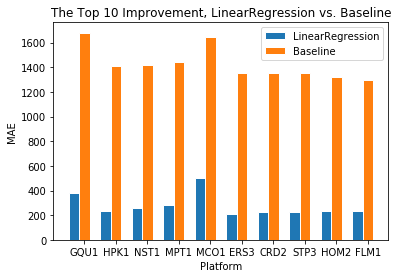

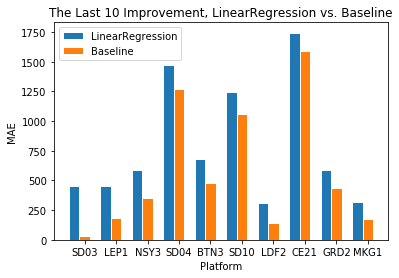

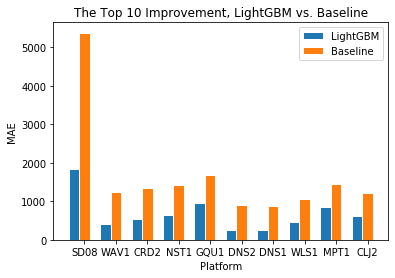

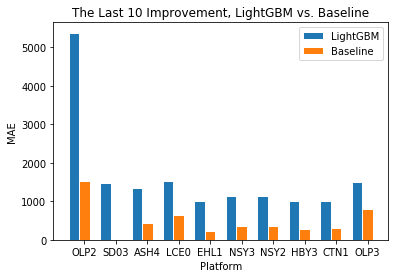

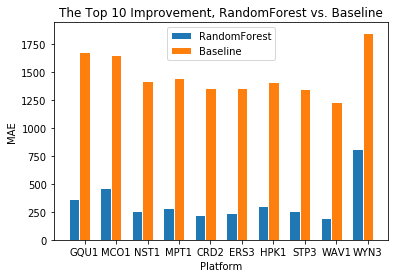

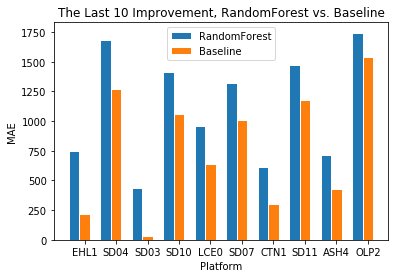

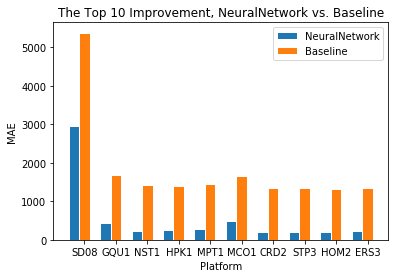

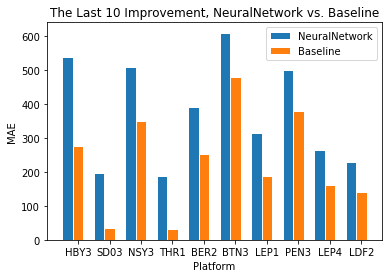

In [73]:
top_k = 10
residual_label = ['LinearRegression', 'Baseline'] 
plot_best_worst_platform(plt_order_r_lr, plt_order_r_bl, top_k, residual_label)

residual_label = ['LightGBM', 'Baseline'] 
plot_best_worst_platform(plt_order_r_lg, plt_order_r_bl, top_k, residual_label)

residual_label = ['RandomForest', 'Baseline'] 
plot_best_worst_platform(plt_order_r_rf, plt_order_r_bl, top_k, residual_label)

residual_label = ['NeuralNetwork', 'Baseline'] 
plot_best_worst_platform(plt_order_r_nn, plt_order_r_bl, top_k, residual_label)